# Demo: preparation

## Import

#### Import for spark

In [1]:
import findspark
findspark.init()
from pyspark.sql import *
from pyspark import SparkConf
from pyspark.sql.functions import *
from pyspark.sql.types import *
import time

#### Import for visualization

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import seaborn as sns

from graphviz import *

from IPython.display import display, HTML

#### Import needed for interaction

In [5]:
# interaction
# from __future__ import print_function
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

#### Start spark engine

In [3]:
#spark.stop()

local = "local[*]"
appName = "Essai graph spark"
memory="8G"

configLocale = SparkConf().setAppName(appName).setMaster(local).\
set("spark.executor.memory", memory).\
set("spark.driver.memory", memory).\
set("spark.sql.catalogImplementation","in-memory")
spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

print("Spark application id is:", sc.applicationId)

Spark application id is: local-1581433000490


## Datasets

In [4]:
DATA_ROOT = "data"
DATA_DIR = DATA_ROOT + "/wiley/"
#DATA_DIR = DATA_ROOT + "/glyphosate/"
#DATA_DIR = DATA_ROOT + "/istex/"

print('DATA-DIR:' + DATA_DIR)

DATA-DIR:data/wiley/


#### Similarity links

In [5]:
similarityLinks = spark.read.json(DATA_DIR + 'similarityLinks')
similarityLinks.show(5, False)

+--------+--------+-------------------+
|idTopic1|idTopic2|similarity         |
+--------+--------+-------------------+
|110     |129     |0.2637034579858007 |
|39      |128     |0.0117574337128808 |
|81      |122     |0.09592078308785146|
|10      |38      |0.03784213838350541|
|161     |192     |0.18799719549152513|
+--------+--------+-------------------+
only showing top 5 rows



#### Topic nodes

In [6]:
topicNodes = spark.read.json(DATA_DIR + 'topicNodes')
# topicNodes.show(1, False)
topicNodes.orderBy("idTopic", desc("weight")).show(20, False)

+-------+------------+---------+------+--------------------+
|idTopic|localTopicId|period   |term  |weight              |
+-------+------------+---------+------+--------------------+
|0      |0           |1996-1998|284153|0.05503559027472268 |
|0      |0           |1996-1998|229917|0.0315334897631547  |
|0      |0           |1996-1998|301364|0.02290491999482694 |
|0      |0           |1996-1998|248801|0.02087863877952271 |
|0      |0           |1996-1998|150899|0.014750267101390652|
|0      |0           |1996-1998|176743|0.01299986771705945 |
|0      |0           |1996-1998|119130|0.011313059961463829|
|0      |0           |1996-1998|49267 |0.011148353785404137|
|0      |0           |1996-1998|124486|0.010226119079083652|
|0      |0           |1996-1998|107504|0.009170965588392133|
|0      |0           |1996-1998|60683 |0.00906412617131097 |
|0      |0           |1996-1998|267109|0.008718388398282782|
|0      |0           |1996-1998|181222|0.006056181743544263|
|0      |0           |19

In [7]:
topicNodes.where("idTopic = 110").show(5, False)

+-------+------------+---------+------+--------------------+
|idTopic|localTopicId|period   |term  |weight              |
+-------+------------+---------+------+--------------------+
|110    |10          |2006-2008|150733|0.021343152963741938|
|110    |10          |2006-2008|82283 |0.02032438978321691 |
|110    |10          |2006-2008|98297 |0.02008320493272858 |
|110    |10          |2006-2008|248801|0.018483870163718896|
|110    |10          |2006-2008|234634|0.018380649583723516|
+-------+------------+---------+------+--------------------+
only showing top 5 rows



#### Term dictionary (terms to display in the global graph)

In [8]:
vocabularies = spark.read.json(DATA_DIR + 'wiley_CS_voc_199620153220')
vocabularies.show(5, False)

+-----+---------------------+
|id   |term                 |
+-----+---------------------+
|156  |101002 cae 101002 cae|
|5745 |ABC concept          |
|6806 |Abstract study       |
|7809 |Anycast services     |
|10821|CR networks          |
+-----+---------------------+
only showing top 5 rows



In [9]:
vocabularies.where("id = 284153").show()

+------+----------+
|    id|      term|
+------+----------+
|284153|techniques|
+------+----------+



#### topicDictionary_unique_10

In [10]:
topicDictionary_unique_10 = spark.read.json(DATA_DIR + 'topicDictionary_unique_10')
topicDictionary_unique_10.show(2, False)
# topicDictionary_unique_10.groupBy().max("idTopic").show()

+-------+---------------------------------------------------------------------------------------------------+
|idTopic|topic                                                                                              |
+-------+---------------------------------------------------------------------------------------------------+
|34     |[solve, solution, problems, compute, case, approximation, analysis, literature, step, terms]       |
|52     |[case, interaction, capable, calculate, terms, validate, experiments, predict, methodology, motion]|
+-------+---------------------------------------------------------------------------------------------------+
only showing top 2 rows



In [11]:
topicDictionary_unique_10.where("idTopic = 110").show(1, False)

+-------+--------------------------------------------------------------------------------------+
|idTopic|topic                                                                                 |
+-------+--------------------------------------------------------------------------------------+
|110    |[impact, complexity, deployment, run, quality, tool, attacks, due, internet, response]|
+-------+--------------------------------------------------------------------------------------+



#### evolutionPath

In [12]:
beta=0.5

nbTopicPerPeriod = 20

pivotDir = str(beta)+"_" + str(nbTopicPerPeriod) + "_0.0_10/"

future = spark.read.json(DATA_DIR + '/evolutionPath/' + pivotDir + "future")
past = spark.read.json(DATA_DIR + '/evolutionPath/' + pivotDir + "past")
labels = spark.read.json(DATA_DIR + '/evolutionPath/' + pivotDir + "labels")

# future.show(1, False)
# past.show(1, False)
# labels.show(1, False)

In [13]:
future.printSchema()

root
 |-- Alpha: double (nullable = true)
 |-- Beta: double (nullable = true)
 |-- Pi: long (nullable = true)
 |-- Pj: long (nullable = true)
 |-- Pk: long (nullable = true)
 |-- Ti: long (nullable = true)
 |-- Tj: long (nullable = true)
 |-- Tk: long (nullable = true)
 |-- TopicI: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- TopicJ: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- TopicK: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- localRank: long (nullable = true)



In [14]:
#labels.printSchema()
labels.createOrReplaceTempView("labels")
print("done")

done


#### Metrics

In [16]:
stats_future = spark.read.json(DATA_DIR + 'statistics_future')

In [17]:
stats_future.printSchema()

root
 |-- Beta: double (nullable = true)
 |-- ConvergenceDegree: double (nullable = true)
 |-- Endyear: long (nullable = true)
 |-- Liveliness: long (nullable = true)
 |-- PivotEvolutionDegree: double (nullable = true)
 |-- RelativeEvolutionDegree: double (nullable = true)
 |-- SplitDegree: double (nullable = true)
 |-- Startyear: long (nullable = true)
 |-- TopicID: long (nullable = true)
 |-- decaying: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- emerging: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- specific: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- stable: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [18]:
stats_future.show(3, False)

+----+-----------------+-------+----------+--------------------+-----------------------+-----------+---------+-------+--------+-----------------------------------------------------------------------------------------------+-------------+-----------------------------------------------------------------------------------+
|Beta|ConvergenceDegree|Endyear|Liveliness|PivotEvolutionDegree|RelativeEvolutionDegree|SplitDegree|Startyear|TopicID|decaying|emerging                                                                                       |specific     |stable                                                                             |
+----+-----------------+-------+----------+--------------------+-----------------------+-----------+---------+-------+--------+-----------------------------------------------------------------------------------------------+-------------+-----------------------------------------------------------------------------------+
|0.1 |6.918            |1998   |9 

#### Draw pivot graphs

##### Get the period list of the given corpus

In [36]:
periodList = topicNodes.select("period").distinct().orderBy("period").collect()
periodList

[Row(period='1996-1998'),
 Row(period='1998-2000'),
 Row(period='2000-2002'),
 Row(period='2002-2004'),
 Row(period='2004-2006'),
 Row(period='2006-2008'),
 Row(period='2008-2010'),
 Row(period='2010-2012'),
 Row(period='2012-2014'),
 Row(period='2014-2015')]

##### Define functions to draw pivot graphs by using Graphviz library

In [47]:
# define timeline graph funtion
def generateSVGSubgraphTimeline(graph, subgraph, periodList):
    pj = subgraph.select(col("Pj").alias("p"))
    pk = subgraph.select(col("Pk").alias("p"))
    p = pj.union(pk).distinct()
    
    # draw timeline
    # period nodes
    for periodId in p.collect():
        graph.node('P'+str(periodId.p), shape="plaintext", label=periodList[periodId[0]][0])
    
    # period edges
    edges = subgraph.select('Pj', 'Pk').distinct()
    for e in edges.collect():
        if (e.Pj < e.Pk):
            graph.edge('P'+str(e.Pj), 'P'+str(e.Pk))
        else:
            graph.edge('P'+str(e.Pk), 'P'+str(e.Pj))
            
    return graph

# g = Digraph('g2', format='png')
# graphTimeline = generateSVGSubgraphTimeline(g, subgraphFuture, periodList)
# graphTimeline


# label topics
def topicLabeling(graph, labels):
    for row in labels.select("Ti","stable", "emerging", "decaying", "specific").collect():
        label = "<table border=\"0\" cellspacing=\"0\">" + \
        "\n                    <tr><td border=\"1\">id:"+ str(row.Ti) + "</td></tr>" + \
        "\n                    <tr><td border=\"1\" bgcolor=\"deepskyblue\">"+ "<br/>".join(row.stable) + "</td></tr>" + \
        "\n                    <tr><td border=\"1\" bgcolor=\"green2\">"+ "<br/>".join(row.emerging) + "</td></tr>" + \
        "\n                    <tr><td border=\"1\" bgcolor=\"red2\">"+ "<br/>".join(row.decaying) + "</td></tr>" + \
        "\n                    <tr><td border=\"1\">"+"<br/>".join(row.specific) + "</td></tr>" +"\n                </table>"
        graph.node(str(row.Ti), shape="none", label="<" + label + ">")
    
    return graph


# align subnodes in pivot graph
def subgraphLabeling(graph, beta, periodList, timeDirection, subgraph, pivotLabels):
    # draw timeline
    graphTimeline = generateSVGSubgraphTimeline(graph, subgraph, periodList)
    
    parentsInPivotGraph = [ (x.Tj) for x in subgraph.select("Tj").distinct().collect()]
    childrenInPivotGraph = [ (x.Tk) for x in subgraph.select("Tk").distinct().collect()]
    topicsInPivotGraph = parentsInPivotGraph + childrenInPivotGraph
    subNodesLabels = pivotLabels.filter(col("Ti").isin(topicsInPivotGraph))
    graphTopicLabels = topicLabeling(graphTimeline, subNodesLabels)
    
    if (timeDirection == "future"):
      for e in subgraph.select( "Tj", "Tk", "Beta").distinct().collect():
        width = str((np.round(e.Beta, 2)-beta)*(10-1)/(1-beta)+1)
        graphTopicLabels.edge(str(e.Tj), str(e.Tk), penwidth=width, label=str(np.round(e.Beta, 2)), fontcolor='red')
    else:
      for e in subgraph.select( "Tk", "Tj", "Beta").distinct().collect():
        width = str((np.round(e.Beta, 2)-beta)*(10-1)/(1-beta)+1)
        graphTopicLabels.edge(str(e.Tk), str(e.Tj), penwidth=width, label=str(np.round(e.Beta, 2)), fontcolor='red')
    
    # align topic nodes {rank: same}
    
    return graphTopicLabels

# draw bidirectional pivot graph    
def bidirectionPivotGraph(graph, beta, periodList, subgraphFuture, subgraphPast, pivotLabels):
    # draw timeline
    graph1 = generateSVGSubgraphTimeline(graph, subgraphFuture, periodList)
    graph2 = generateSVGSubgraphTimeline(graph1, subgraphPast, periodList)
    
    parentsInPivotGraphFuture = [ (x.Tj) for x in subgraphFuture.select("Tj").distinct().collect()]
    childrenInPivotGraphFuture = [ (x.Tk) for x in subgraphFuture.select("Tk").distinct().collect()]
    parentsInPivotGraphPast = [ (x.Tj) for x in subgraphPast.select("Tj").distinct().collect()]
    childrenInPivotGraphPast = [ (x.Tk) for x in subgraphPast.select("Tk").distinct().collect()]
    topicsInPivotGraph = parentsInPivotGraphFuture + childrenInPivotGraphFuture + parentsInPivotGraphPast + childrenInPivotGraphPast
    # label topics in pivot graph
    subNodesLabels = pivotLabels.filter(col("Ti").isin(topicsInPivotGraph))
    graphTopicLabels = topicLabeling(graph2, subNodesLabels)
    
    nodeLinksFuture = subgraphFuture.select( col("Tj").alias("From"), col("Tk").alias("To"), col("Beta")).distinct()
    nodeLinksPast = subgraphPast.select( col("Tk").alias("From"), col("Tj").alias("To"), col("Beta")).distinct()
    nodeLinks = nodeLinksFuture.union(nodeLinksPast)
    for e in nodeLinks.collect():
        width = str((np.round(e.Beta, 2)-beta)*(10-1)/(1-beta)+1)
        graphTopicLabels.edge(str(e.From), str(e.To), penwidth=width, label=str(np.round(e.Beta, 2)), fontcolor='red')
    
    # align topic nodes {rank: same}   
    
    return graphTopicLabels
    
print("fonction defined!")    

fonction defined!


In [48]:
def drawPivotGraph(beta, subgraphFuture, subgraphPast, periodList, pivotLabels):
    g = Digraph('G', format='png')
    if ((subgraphFuture.count() == 0) and (subgraphPast.count() > 0)):
      g = subgraphLabeling(g, beta, periodList, "past", subgraphPast, pivotLabels)
    elif ((subgraphFuture.count() > 0) and (subgraphPast.count() == 0)):
      g = subgraphLabeling(g, beta, periodList, "future", subgraphFuture, pivotLabels)
    else:
      g = bidirectionPivotGraph(g, beta, periodList, subgraphFuture, subgraphPast, pivotLabels)

    return g

##### Here we make an example

In [49]:
### beta has been given above
topicId = 113
subgraphFuture = future.where(col("Ti") == topicId)
subgraphPast = past.where(col("Ti") == topicId)

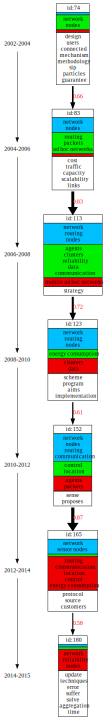

In [56]:
g = drawPivotGraph(beta, subgraphFuture, subgraphPast, periodList, labels)
g.attr(size = '10')
g